### Import Libraries and Read Data

In [25]:
## Import Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [27]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
# new source https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [28]:
req = requests.get(download_link)
rki_raw = pd.read_csv(StringIO(req.text))

In [29]:
rki_raw.tail()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen
101182,16,Thüringen,LK Greiz,A35-A59,W,1,0,2607521,2020-03-28T00:00:00.000Z,16076,"17.04.2020, 00:00 Uhr",0,-9,2020-03-20T00:00:00.000Z,0,1
101183,16,Thüringen,LK Greiz,A35-A59,W,1,0,2607522,2020-03-28T00:00:00.000Z,16076,"17.04.2020, 00:00 Uhr",0,-9,2020-03-23T00:00:00.000Z,-9,0
101184,16,Thüringen,LK Greiz,A35-A59,W,2,0,2607523,2020-03-28T00:00:00.000Z,16076,"17.04.2020, 00:00 Uhr",0,-9,2020-03-26T00:00:00.000Z,0,2
101185,16,Thüringen,LK Greiz,A35-A59,W,1,0,2607524,2020-03-29T00:00:00.000Z,16076,"17.04.2020, 00:00 Uhr",0,-9,2020-03-20T00:00:00.000Z,0,1
101186,16,Thüringen,LK Greiz,A35-A59,W,2,0,2607525,2020-03-29T00:00:00.000Z,16076,"17.04.2020, 00:00 Uhr",0,-9,2020-03-25T00:00:00.000Z,0,2


In [30]:
def new_cases_by_date(rki_raw, rki_flag_column='Neuer Fall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Meldedatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [32]:
rki_cases = new_cases_by_date(rki_raw, rki_flag_column='NeuerFall', rki_count_columns='AnzahlFall')
rki_death = new_cases_by_date(rki_raw, rki_flag_column='NeuerTodesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='NeuGenesen', rki_count_columns='AnzahlGenesen')

In [33]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeath', 'AnzahlGenesen': 'NewRecovered'}
rki.rename(columns_dict, axis=1, inplace=True)
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeath,NewRecovered
Meldedatum,,,
2020-04-12 00:00:00+00:00,1820,41.0,158.0
2020-04-13 00:00:00+00:00,1583,44.0,115.0
2020-04-14 00:00:00+00:00,2337,51.0,190.0
2020-04-15 00:00:00+00:00,2868,22.0,179.0
2020-04-16 00:00:00+00:00,1143,15.0,66.0


In [34]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,
2020-04-07 00:00:00+00:00,5107,147.0,1708.0,107854,3314.0,77938.0,29916.0,0.170711
2020-04-08 00:00:00+00:00,5219,154.0,1335.0,113073,3468.0,79273.0,33800.0,0.154408
2020-04-09 00:00:00+00:00,4856,120.0,985.0,117929,3588.0,80258.0,37671.0,0.128906
2020-04-10 00:00:00+00:00,3252,63.0,514.0,121181,3651.0,80772.0,40409.0,0.080477
2020-04-11 00:00:00+00:00,2898,44.0,314.0,124079,3695.0,81086.0,42993.0,0.067406
2020-04-12 00:00:00+00:00,1820,41.0,158.0,125899,3736.0,81244.0,44655.0,0.040757
2020-04-13 00:00:00+00:00,1583,44.0,115.0,127482,3780.0,81359.0,46123.0,0.034321
2020-04-14 00:00:00+00:00,2337,51.0,190.0,129819,3831.0,81549.0,48270.0,0.048415
2020-04-15 00:00:00+00:00,2868,22.0,179.0,132687,3853.0,81728.0,50959.0,0.056281


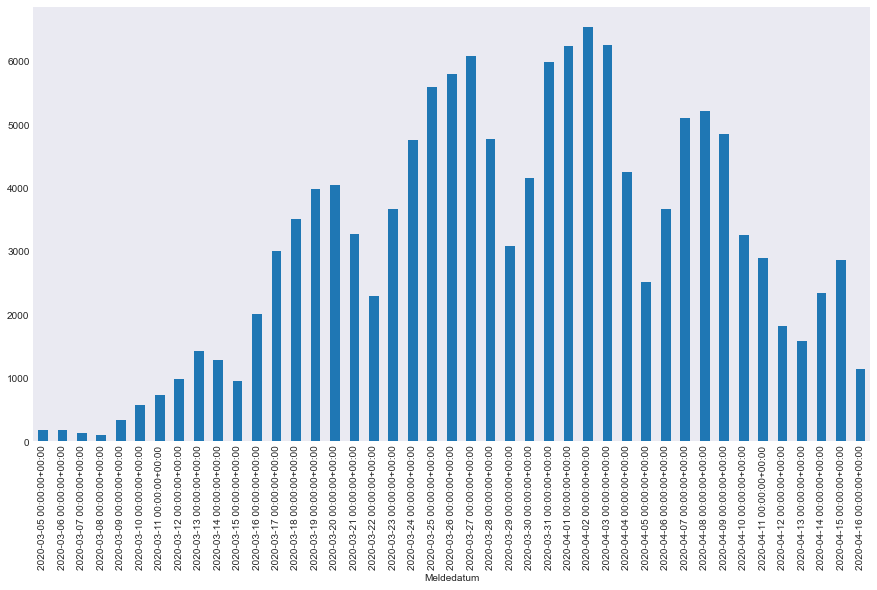

In [35]:
rki.NewCases['03-05-2020':].plot.bar()

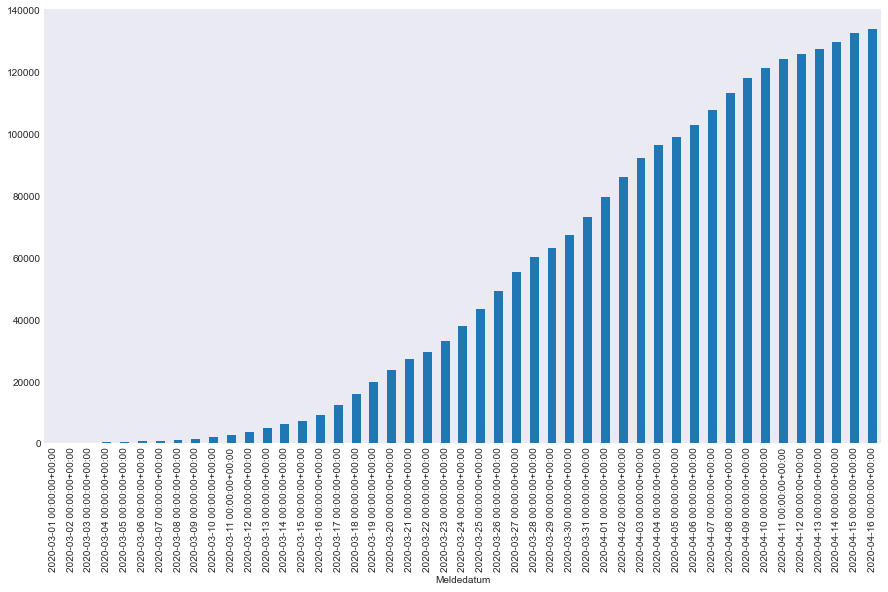

In [36]:
rki.Cases['03-01-2020':].plot.bar()

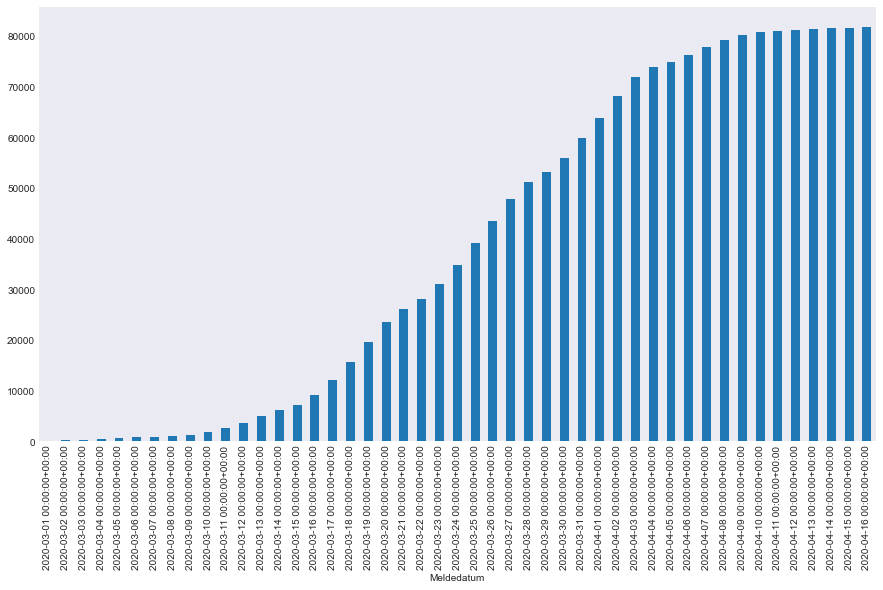

In [37]:
rki.Recovered['03-01-2020':].plot.bar()

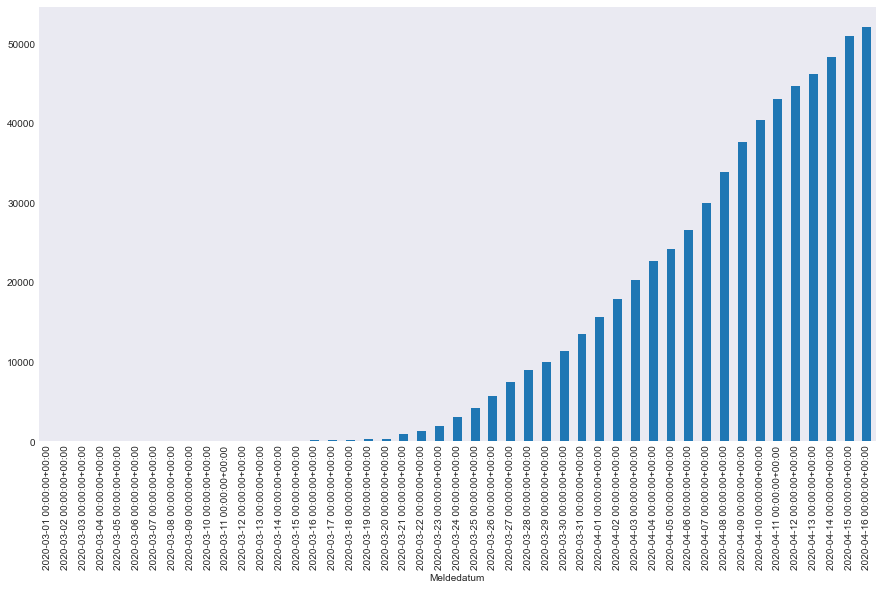

In [38]:
rki.ActiveCases['03-01-2020':].plot.bar()

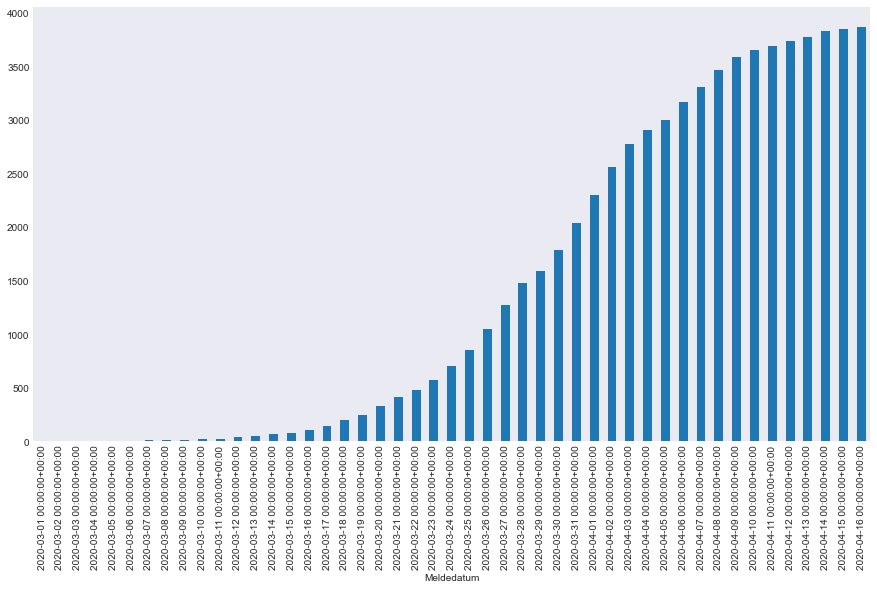

In [39]:
rki.Death['03-01-2020':].plot.bar()

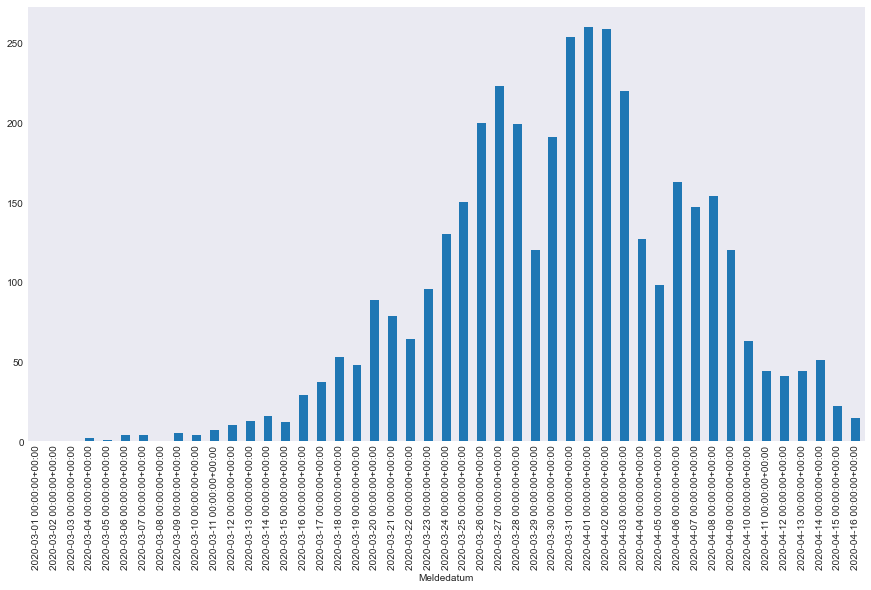

In [40]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

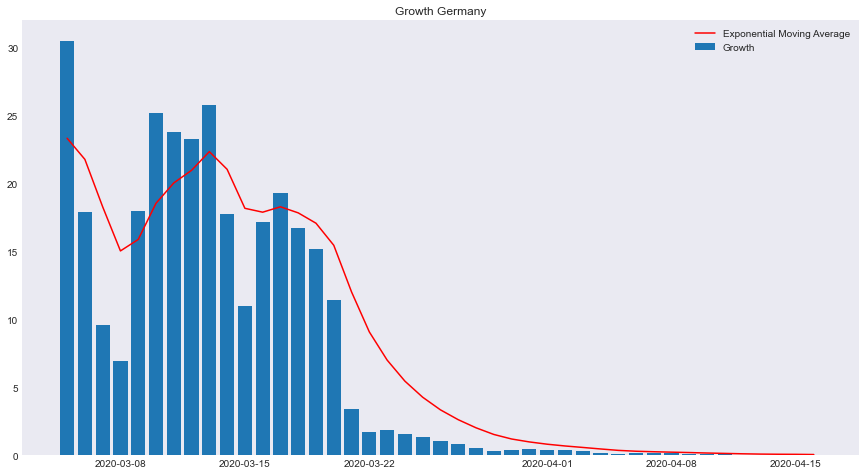

In [41]:
start_date = '03-05-2020'
x = rki[start_date:].index

plt.bar(x, rki.Growth[start_date:], label='Growth')
plt.plot(x, rki.Growth.ewm(span=6,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

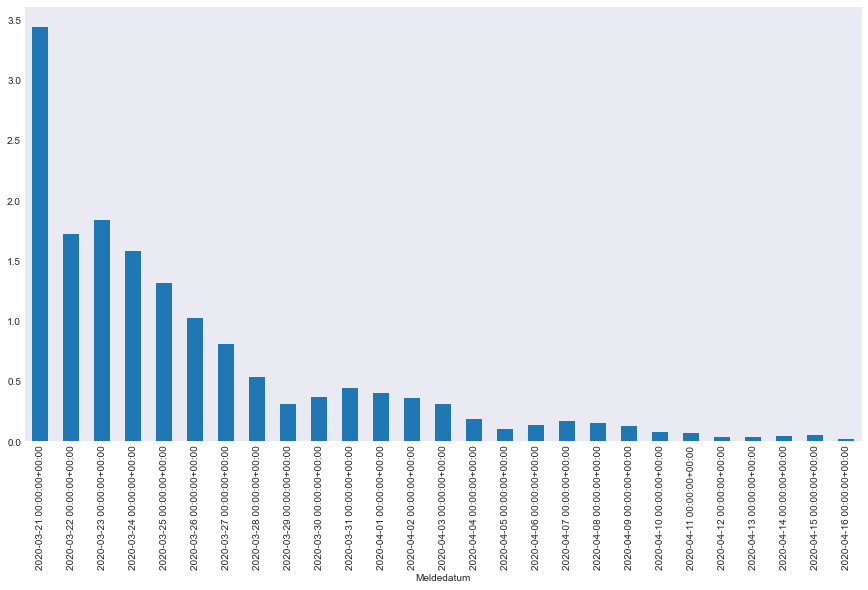

In [42]:
rki.Growth['03-21-2020':].plot.bar()

Text(0.5, 1.0, 'New Cases Germany')

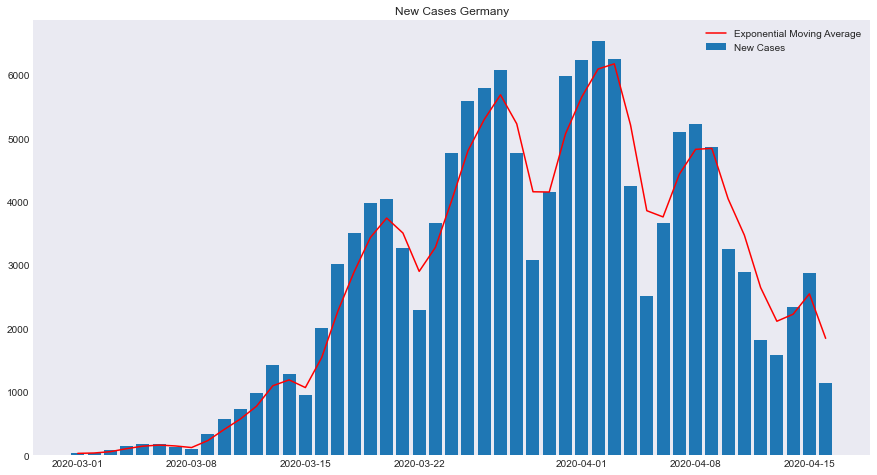

In [43]:
start_date = '03-01-2020'
x = rki[start_date:].index

plt.bar(x, rki.NewCases[start_date:], label='New Cases')
plt.plot(x, rki.NewCases.ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('New Cases Germany')

In [44]:
rki.tail(20)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,
2020-03-28 00:00:00+00:00,4771,199.0,3323.0,60086,1475.0,51149.0,8937.0,0.533848
2020-03-29 00:00:00+00:00,3085,120.0,2090.0,63171,1595.0,53239.0,9932.0,0.310612
2020-03-30 00:00:00+00:00,4149,191.0,2704.0,67320,1786.0,55943.0,11377.0,0.364683
2020-03-31 00:00:00+00:00,5990,254.0,3909.0,73310,2040.0,59852.0,13458.0,0.445088
2020-04-01 00:00:00+00:00,6234,260.0,4044.0,79544,2300.0,63896.0,15648.0,0.398390
2020-04-02 00:00:00+00:00,6533,259.0,4238.0,86077,2559.0,68134.0,17943.0,0.364097
2020-04-03 00:00:00+00:00,6257,220.0,3864.0,92334,2779.0,71998.0,20336.0,0.307681
2020-04-04 00:00:00+00:00,4244,127.0,1862.0,96578,2906.0,73860.0,22718.0,0.186812
2020-04-05 00:00:00+00:00,2507,98.0,1000.0,99085,3004.0,74860.0,24225.0,0.103488
